# COGS 108 - Final Project (change this to your project's title)

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [X] YES - make available
* [   ] NO - keep private

# Overview

*Fill in your overview here*

# Names

- Brandon Luong
- Noel Molina
- Margarita Leonova
- Tatiana Bimatova
- Huy Le

<a id='research_question'></a>
# Research Question

What characteristics of beer (flavors like bitter/sweet/sour/spicy etc.; alcohol percentage; color) influence the rating of beer (Plainly speaking, what kind of beer do people like more)?

<a id='background'></a>

## Background & Prior Work

Beer is the most popular alcoholic drink in the world. Even if we take into consideration all drinks, beer is second only (!) to tea and water [^wiki].

Beer is an alcoholic beverage created from combining 4 main ingredients: water, malt, hops and yeast. The alcohol content in beer is created through yeast fermentation. Depending on the fermentation process, beer will be classified as ale or lager. Under these categories are more specific styles, such as pale ale, India pale ale (IPA), stouts, etc. [^wiki].

Several beer rating websites show that stouts (namely the ones with higher alcohol percentage of 10% and more) tend to have very high consumer ratings. 

Recent research [^manikas] suggests that higher ABV (alcohol by volume) correlated significantly and positively with higher consumer ratings while the higher length of a review correlated negatively with the rating score. 

Another research [^janish] supports the relationship between a higher ABV and consumer rating.

In a “A genome-wide association study of bitter and sweet beverage consumption” [^zhong], the authors found that people’s “taste preferences for bitter or sweet beverages aren't based on variations in our taste genes, but rather genes related to the psychoactive properties of these beverages”. In other words, people like bitter beverages not for their taste, but for the effect these beverages have on us.

However we were not able to find a research that shows correlation between beer flavor and color characteristics and higher ratings.

-------------------------------------------------------------------------------------------

[^wiki]: Beer. https://en.wikipedia.org/wiki/Beer

[^manikas]: Andrew Manikas, Michael Godfrey and Jason Woldt. (2022) What drives higher beer ratings? Evidence from Big Data. *Econpapers*. https://econpapers.repec.org/article/ibfijmmre/v_3a15_3ay_3a2022_3ai_3a1_3ap_3a1-13.htm

[^janish]: Scott Janish. Relationship of ABV to Beer Scores. *http://scottjanish.com/*. http://scottjanish.com/relationship-of-abv-to-beer-scores/

[^zhong]: Victor W Zhong, Alan Kuang, Rebecca D Danning, Peter Kraft, Rob M van Dam, Daniel I Chasman, Marilyn C Cornelis. (02 May 2019) A genome-wide association study of bitter and sweet beverage consumption. *Human Molecular Genetics*. https://academic.oup.com/hmg/article/28/14/2449/5424254

# Hypothesis


According to the Beer Advocate and Untappd ratings, the majority of the top rated beers are stouts. Therefore, we hypothesize that characteristics like higher alcohol percentage (10% and more), bitter-sweet taste and dark color contribute the most to the higher rating.

Sources:

https://www.beeradvocate.com/beer/top-rated/us/

https://untappd.com/beer/top_rated

# Dataset(s)

Our ideal dataset would include beer name, its type and rating. We also want characteristics of the beer, such as ABV, flavor characteristics, color.

We think that internet scraping won’t be suitable for our purposes. We want a dataset that comes from a large poll or a rating resource like Untappd or BeerAdvocate. These resources provide hundreds of customer reviews as well as beer characteristics.

Our observation would be a single customer review with a beer rating. We want the most recent data we can find because we’re not much interested in what people liked a long time ago.


Here are some real datasets we could potentially use:

https://www.kaggle.com/datasets/jailenbailey/untappd-beer-data?resource=download (Untappd beer data)

https://www.kaggle.com/datasets/rdoume/beerreviews (Beer reviews)


Untappd beer data contain beer name, style, and brewing company. Each beer listed has their alcohol content and measure of bitterness displayed. Additionally, there are comments from consumers detailing what they like about a specific beer or what their overall review was.


Beer reviews contain the type of beer (labeled as beer style) and its brewing company. There are numeric ratings (on a scale of 1-5) for beer aroma, taste, appearance, and overall final score of beer. 


These datasets contain both beer style and brewing company. However, Untapped beer data gives qualitative information regarding beer likes as it contains comments from consumers about the beer they tasted. Meanwhile, Beer reviews contain quantitative data on beer characteristics as consumers rated aroma, taste, and appearance on a numeric scale. 


# Setup

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

In [136]:
beer_data_set = pd.read_csv('beer_data_set.csv')
descriptors = pd.ExcelFile('Beer Descriptors Simplified.xlsx')
beer_descriptors = []#pd.read_excel('Beer Descriptors Simplified.xlsx')
for sheet in descriptors.sheet_names:
    df = descriptors.parse(sheet)
    beer_descriptors.append(df)
description_df = pd.concat(beer_descriptors, ignore_index=False, axis=1)

# Data Cleaning


Our data cleaning process:

We first looked at the columns and dropped unnecessary columns and renamed columns for simplicity. We then checked for missing values in the data set and dropped the rows that contained missing beer entries (there were not many missing values). There are 11 descriptors for each beer. To handle the many descriptors, we grouped each into one of three categores: 'flavor and aroma', 'mouthfeel', 'taste'. Many beer styles were the same but contained little difference, for example: 'IPA - Hazy' and 'IPA - Summer'. We grouped these similiar beer styles so that we can better group the beers themselves, for example: grouping those IPAs into one overall IPA style. Finally, the descriptors for each bear had a score based on the number of descriptor words used for that beer. Since there were a different number of potential descriptor words for each, we standardized each score to be able to better compare the beers. 

In [138]:
# remove impact columns from the descriptions dataframe
description_df = description_df.drop(description_df.filter(regex='Impact').columns, axis=1)
# lowercase the column names
description_df.columns = description_df.columns.str.lower()
# rename columns to match the descriptors in both data sets
description_df = description_df.rename(columns = {'spices':'spicy', 'alcoholic':'alcohol'})
description_df

# lowercase the column names
beer_data_set.columns = beer_data_set.columns.str.lower()
# drop 'style key' column and rename 'name' column to 'beer'
beer_data_set = (beer_data_set.drop(columns = ['style key'])
        .rename(columns = {'name': 'beer', 'astringency':'astringent', 'fruits':'fruity', 'spices':'spicy'})
)
beer_data_set

# checking for missing values
beer_data_set.isna().sum()

# drop rows that contain missing beer entries
beer_data_set = beer_data_set[beer_data_set['beer'].notna()]
beer_data_set.head()

,beer,key,style,brewery,description,abv,ave rating,min ibu,max ibu,astringent,body,alcohol,bitter,sweet,sour,salty,fruity,hoppy,spicy,malty
0,Amber,251,Altbier,Alaskan Brewing Co.,"Notes:Richly malty and long on the palate, wit...",5.3,3.65,25,50,13,32,9,47,74,33,0,33,57,8,111
1,Double Bag,252,Altbier,Long Trail Brewing Co.,"Notes:This malty, full-bodied double alt is al...",7.2,3.90,25,50,12,57,18,33,55,16,0,24,35,12,84
2,Long Trail Ale,253,Altbier,Long Trail Brewing Co.,Notes:Long Trail Ale is a full-bodied amber al...,5.0,3.58,25,50,14,37,6,42,43,11,0,10,54,4,62
3,Doppelsticke,254,Altbier,Uerige Obergärige Hausbrauerei,Notes:,8.5,4.15,25,50,13,55,31,47,101,18,1,49,40,16,119
4,Scurry,255,Altbier,Off Color Brewing,Notes:Just cause it's dark and German doesn't ...,5.3,3.67,25,50,21,69,10,63,120,14,0,19,36,15,218


In [139]:
# group the descriptors into three groups: 'flavor and aroma', 'mouthfeel', 'taste'
mouthfeel = ['astringent',	'body',	'alcohol']
taste = ['bitter', 'sweet', 'sour', 'salty']
flavor_and_aroma = ['fruity', 'hoppy', 'spicy', 'malty']
beer_data_set['mouthfeel'] = beer_data_set[mouthfeel].sum(axis=1)
beer_data_set['taste'] = beer_data_set[taste].sum(axis=1)
beer_data_set['flavor_and_aroma'] = beer_data_set[flavor_and_aroma].sum(axis=1)
beer_data_set

# aggregated the style of beers into common groups. ex: IPA, Lager, etc.
beer_data_set['style'] = beer_data_set['style'].apply(lambda x: x.split('-')[0])
beer_data_set

# number of beers for each style
beer_data_set['style'].value_counts()

#check for duplicate beers
beer_data_set['beer'].value_counts()

# aggregate the data so that there is only one review for each beer
beer_data_set = beer_data_set.groupby(['style', 'beer']).mean().reset_index()
beer_data_set.head()

,style,beer,key,abv,ave rating,min ibu,max ibu,astringent,body,alcohol,...,sweet,sour,salty,fruity,hoppy,spicy,malty,mouthfeel,taste,flavor_and_aroma
0,Altbier,ALTerior Motive,297.0,6.3,4.05,25.0,50.0,27.0,61.0,11.0,...,61.0,46.0,0.0,40.0,77.0,14.0,110.0,99.0,163.0,241.0
1,Altbier,Ad Astra Ale,264.0,5.6,3.69,25.0,50.0,7.0,30.0,5.0,...,43.0,13.0,1.0,13.0,50.0,6.0,93.0,42.0,100.0,162.0
2,Altbier,Alt-eration Ale,271.0,5.0,3.81,25.0,50.0,21.0,43.0,3.0,...,54.0,7.0,0.0,10.0,60.0,9.0,111.0,67.0,115.0,190.0
3,Altbier,Altbier,262.0,4.7,4.00,25.0,50.0,34.0,48.0,9.0,...,59.0,25.0,1.0,32.0,68.0,12.0,121.0,91.0,140.0,233.0
4,Altbier,Alternate Dimension,300.0,5.6,3.66,25.0,50.0,25.0,50.0,12.0,...,61.0,20.0,0.0,21.0,59.0,26.0,139.0,87.0,153.0,245.0


In [140]:
# check if the values in the descriptors aren't greater than the amount of descriptive words
check_desc = beer_data_set.set_index('beer').iloc[:, 5:].reset_index()
for desc in description_df.columns:
    check_desc[desc] = description_df[desc].dropna().count() - check_desc[desc]

# we can see that there are some negative values in the descriptor fields. This implies that the same word was used more than once to describe the beer.
check_desc

# the number of impact words for each beer feature
num_desc_words = np.invert(description_df.isna()).sum()


mouthfeel = ['astringent',	'body',	'alcohol']
taste = ['bitter', 'sweet', 'sour', 'salty']
flavor_and_aroma = ['fruity', 'hoppy', 'spicy', 'malty']
# the number of descriptors for each group
num_mouthfeel = np.invert(description_df[mouthfeel].isna()).sum().sum()
num_taste = np.invert(description_df[taste].isna()).sum().sum()
num_flavor = np.invert(description_df[flavor_and_aroma].isna()).sum().sum()

In [141]:
# standardize the descriptors and descriptor groups
beer_data_set['astringent'] = beer_data_set['astringent'].apply(lambda x: x  / num_desc_words.loc['astringent'])

beer_data_set['body'] = beer_data_set['body'].apply(lambda x: x  / num_desc_words.loc['body'])

beer_data_set['alcohol'] = beer_data_set['alcohol'].apply(lambda x: x  / num_desc_words.loc['alcohol'])

beer_data_set['bitter'] = beer_data_set['bitter'].apply(lambda x: x  / num_desc_words.loc['bitter'])

beer_data_set['sweet'] = beer_data_set['sweet'].apply(lambda x: x  / num_desc_words.loc['sweet'])

beer_data_set['sour'] = beer_data_set['sour'].apply(lambda x: x  / num_desc_words.loc['sour'])

beer_data_set['salty'] = beer_data_set['salty'].apply(lambda x: x  / num_desc_words.loc['salty'])

beer_data_set['fruity'] = beer_data_set['fruity'].apply(lambda x: x  / num_desc_words.loc['fruity'])

beer_data_set['hoppy'] = beer_data_set['hoppy'].apply(lambda x: x  / num_desc_words.loc['hoppy'])

beer_data_set['spicy'] = beer_data_set['spicy'].apply(lambda x: x  / num_desc_words.loc['spicy'])

beer_data_set['malty'] = beer_data_set['malty'].apply(lambda x: x  / num_desc_words.loc['malty'])

beer_data_set['mouthfeel'] = beer_data_set['mouthfeel'].apply(lambda x: x  / num_mouthfeel)

beer_data_set['taste'] = beer_data_set['taste'].apply(lambda x: x  / num_taste)

beer_data_set['flavor_and_aroma'] = beer_data_set['flavor_and_aroma'].apply(lambda x: x  / num_taste)

In [142]:
# final clean data set
final = beer_data_set
final.head()


,style,beer,key,abv,ave rating,min ibu,max ibu,astringent,body,alcohol,...,sweet,sour,salty,fruity,hoppy,spicy,malty,mouthfeel,taste,flavor_and_aroma
0,Altbier,ALTerior Motive,297.0,6.3,4.05,25.0,50.0,0.303371,0.628866,0.171875,...,0.476562,0.414414,0.000000,0.229885,0.520270,0.141414,0.526316,0.396,0.482249,0.713018
1,Altbier,Ad Astra Ale,264.0,5.6,3.69,25.0,50.0,0.078652,0.309278,0.078125,...,0.335938,0.117117,0.076923,0.074713,0.337838,0.060606,0.444976,0.168,0.295858,0.479290
2,Altbier,Alt-eration Ale,271.0,5.0,3.81,25.0,50.0,0.235955,0.443299,0.046875,...,0.421875,0.063063,0.000000,0.057471,0.405405,0.090909,0.531100,0.268,0.340237,0.562130
3,Altbier,Altbier,262.0,4.7,4.00,25.0,50.0,0.382022,0.494845,0.140625,...,0.460938,0.225225,0.076923,0.183908,0.459459,0.121212,0.578947,0.364,0.414201,0.689349
4,Altbier,Alternate Dimension,300.0,5.6,3.66,25.0,50.0,0.280899,0.515464,0.187500,...,0.476562,0.180180,0.000000,0.120690,0.398649,0.262626,0.665072,0.348,0.452663,0.724852


# Data Analysis & Results

[Text(0.5, 1.0, 'Alcohol Percentage (ABV) vs. Average Rating')]

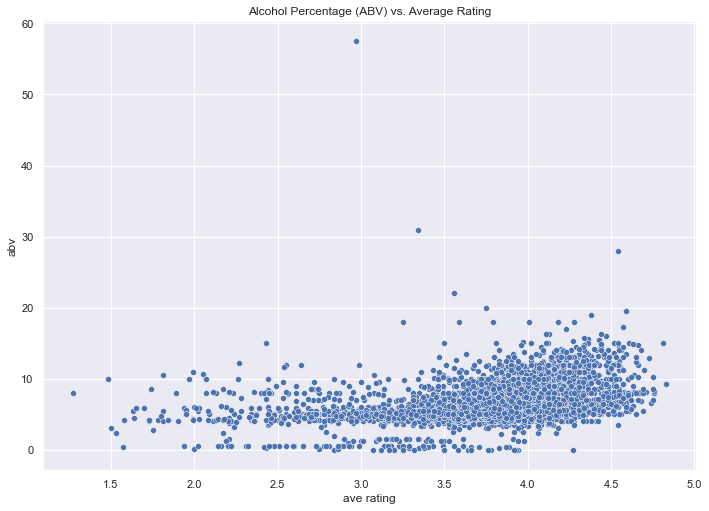

In [143]:
# Alcohol Percentage (ABV) vs. Average Rating
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data = final, x = 'ave rating', y = 'abv').set(title='Alcohol Percentage (ABV) vs. Average Rating')

We can see that there are a few outliers with a very high alcohol percentage that we probably don't wanna include as it doesn't really make sense to consider those drinks as beers. We'll get rid of the two that have ABV > 25%.
We can also see a cluster of beers at the bottom of the graph with a really low ABV, so it makes sense to differentiate between the two gropus. We made a new column "is alcoholic" to differentiate alcoholic vs non/low alcoholic beers based on 2.5% ABV. This is the threshold according to federal law[^fedLaw]


[^fedLaw]: https://www.ttb.gov/images/pdfs/beer-bam/chapter1.pdf

In [144]:
new_final = final[final['abv'] <= 25] # took 3 beers that were above 25% alcohol
new_final['Is Alcoholic'] = (new_final['abv'] > 2.5) # created new column to distinguish alcoholic beers vs. non/low alcoholic beers (> 2.5 abv)

[Text(0.5, 1.0, 'Alcohol Percentage (ABV) vs. Average Rating: Outliers Removed')]

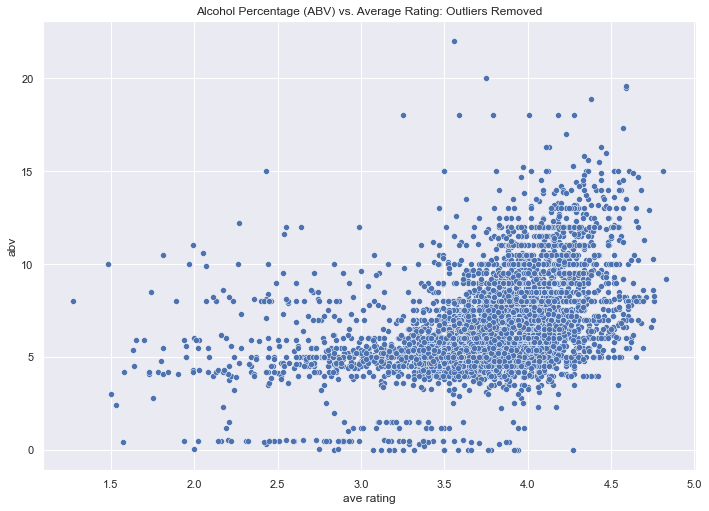

In [145]:
# Scatterplot without outliers
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data = new_final, x = 'ave rating', y = 'abv').set(title='Alcohol Percentage (ABV) vs. Average Rating: Outliers Removed')

We first grouped beers by style and aggragated to find the mean of the ABV (alcohol by volume). We sorted the means of each style in increasing order and graphed the data as shown above. There is a significant difference in the 2 lowest ABV beers and 2 highest ABV beers. The styles Low Alcohol Beer and Kvass have ABV's of around 0.5 and 1.8 respectively, with the next highest beer having an ABV of around 4.2. Similarly, the top two beers by ABV have about 1 ABV unit higher than the next lowest beer by ABV.

[Text(0.5, 1.0, 'Styles by Alcohol Percentage')]

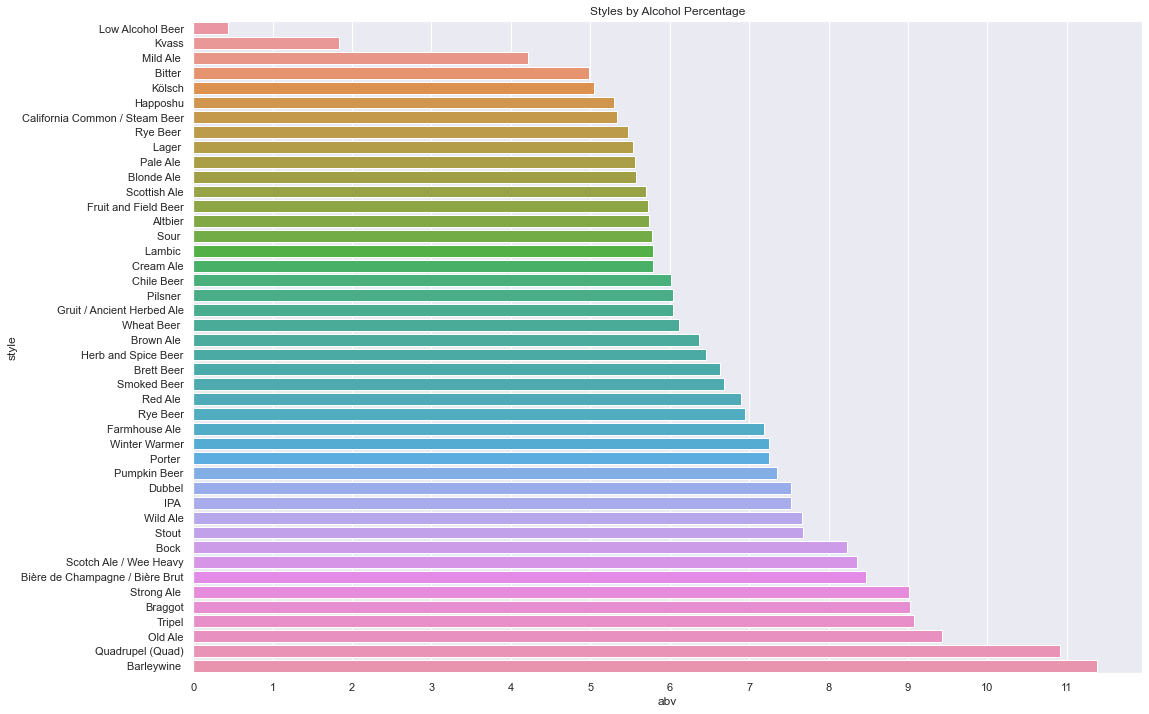

In [146]:
final_grouped = new_final.groupby('style').mean().reset_index().sort_values('abv')
sns.set(rc = {'figure.figsize':(17,12)})
g = sns.barplot(data = final_grouped, x = 'abv', y = 'style')
g.set_xticks(range(12))
g.set(title='Styles by Alcohol Percentage')

[Text(0.5, 1.0, 'Styles by Average Rating')]

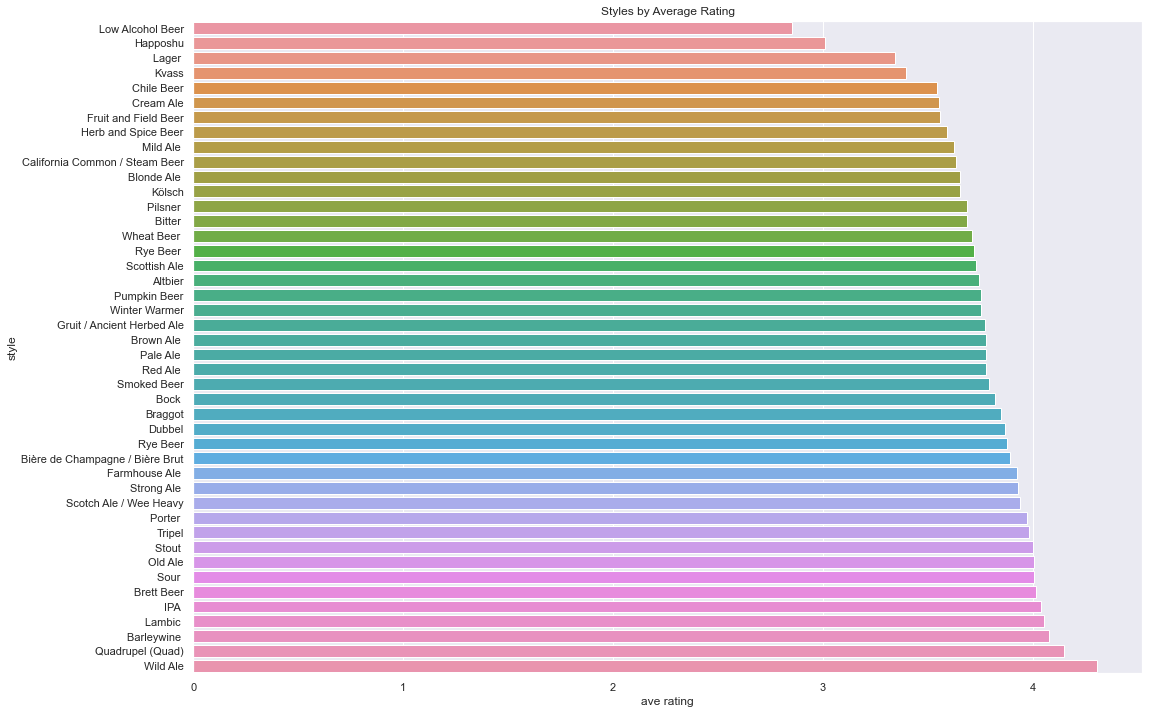

In [147]:
final_grouped2 = new_final.groupby('style').mean().reset_index().sort_values('ave rating')
sns.set(rc = {'figure.figsize':(17,12)})
g = sns.barplot(data = final_grouped2, x = 'ave rating', y = 'style')
g.set_xticks(range(5))
g.set(title='Styles by Average Rating')

We then looked at the average ratings of all of the beer styles. There appears to be no significant difference in average ratings when we look at the vast majority of the styles. It is interesting to note many of the beer styles appear to be in the same order as the previous bar graph. This implies there may be a correlation between ABV and average ratings for the different beer styles. 

AttributeError: module 'seaborn' has no attribute 'move_legend'

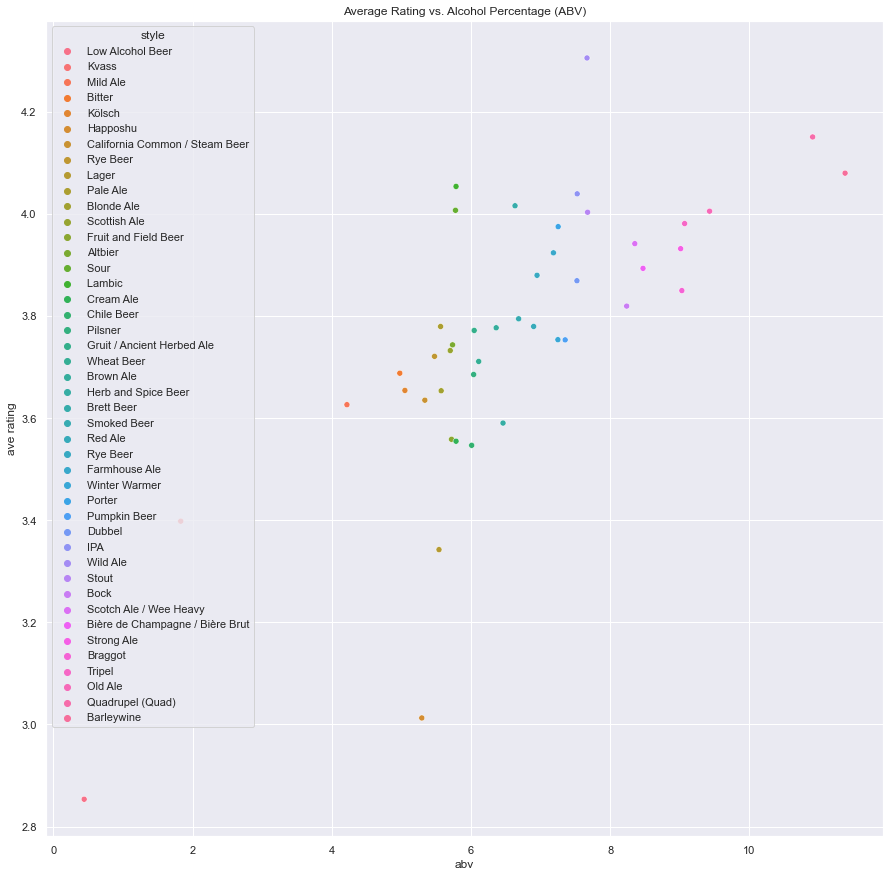

In [148]:
sns.set(rc = {'figure.figsize':(15,15)})
ax = sns.scatterplot(data = final_grouped, x = 'abv', y = 'ave rating', hue = 'style')
ax.set(title='Average Rating vs. Alcohol Percentage (ABV)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Here's a scatterplot between ABV and Avg Rating to get a better idea of their relationship after looking after the barplots above.
There's clearly a positive trend between ABV and Average Rating for the different beer styles. It appears that the beer style with higher ABV has higher average rating. 

Text(0.5, 0, 'Malty distribution')

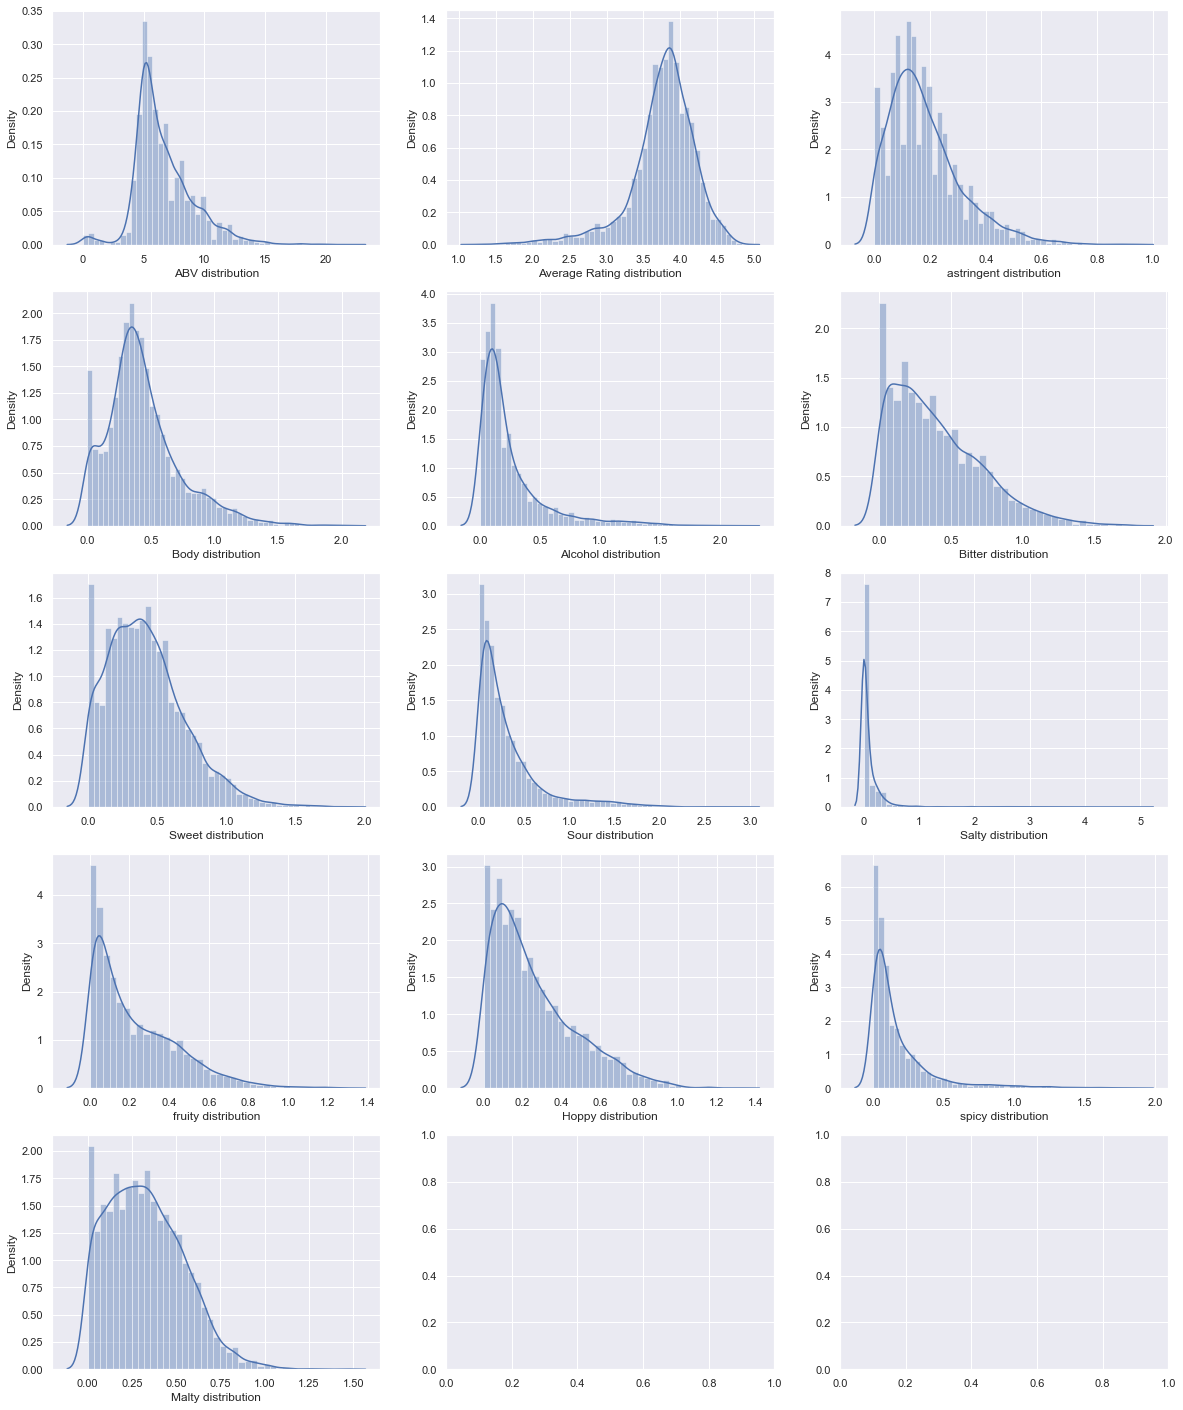

In [152]:
# Distributions
fig, axes = plt.subplots(nrows=5, ncols = 3, figsize = (20, 25))
plt.subplot(5, 3, 1)
sns.distplot(new_final['abv'])
plt.xlabel('ABV distribution')

plt.subplot(5, 3, 2)
sns.distplot(new_final['ave rating'])
plt.xlabel('Average Rating distribution')

plt.subplot(5, 3, 3)
sns.distplot(new_final['astringent'])
plt.xlabel('astringent distribution')

plt.subplot(5, 3, 4)
sns.distplot(new_final['body'])
plt.xlabel('Body distribution')

plt.subplot(5, 3, 5)
sns.distplot(new_final['alcohol'])
plt.xlabel('Alcohol distribution')

plt.subplot(5, 3, 6)
sns.distplot(new_final['bitter'])
plt.xlabel('Bitter distribution')

plt.subplot(5, 3, 7)
sns.distplot(new_final['sweet'])
plt.xlabel('Sweet distribution')

plt.subplot(5, 3, 8)
sns.distplot(new_final['sour'])
plt.xlabel('Sour distribution')

plt.subplot(5, 3, 9)
sns.distplot(new_final['salty'])
plt.xlabel('Salty distribution')

plt.subplot(5, 3, 10)
sns.distplot(new_final['fruity'])
plt.xlabel('fruity distribution')

plt.subplot(5, 3, 11)
sns.distplot(new_final['hoppy'])
plt.xlabel('Hoppy distribution')

plt.subplot(5, 3, 12)
sns.distplot(new_final['spicy'])
plt.xlabel('spicy distribution')

plt.subplot(5, 3, 13)
sns.distplot(new_final['malty'])
plt.xlabel('Malty distribution')

In [126]:
#fig1 = sns.pairplot(data = new_final[['style', 'abv', 'ave rating', 'min ibu', 'max ibu', 'astringency', 'Is Alcoholic']], hue = 'Is Alcoholic')
#fig1.fig.suptitle('Pairwise Relationships Between Style, Alcohol Percentage (ABV), Average Rating, Bitterness', y=1.05)

CHANGE BASED ON NEW DESTRIBUTIONS!
The distributions for ABV, Avg rating and astringency seem to have a skewed distribution. 
Here we explored the distributions of variables representing the taste characteristics. 
Distributions:
- Avg rating looks like a normal distribution
- fruity, hoppy, spicy, malty, bitter, sweet, sour, salty all appear to be right skewed. Which makes sense becacuse too much of particular flavor characteristic (for example, if the beer is too sour) can get overwhelming and not pleasant to drink. 


[Text(0.5, 1.0, 'Average Rating vs Malty')]

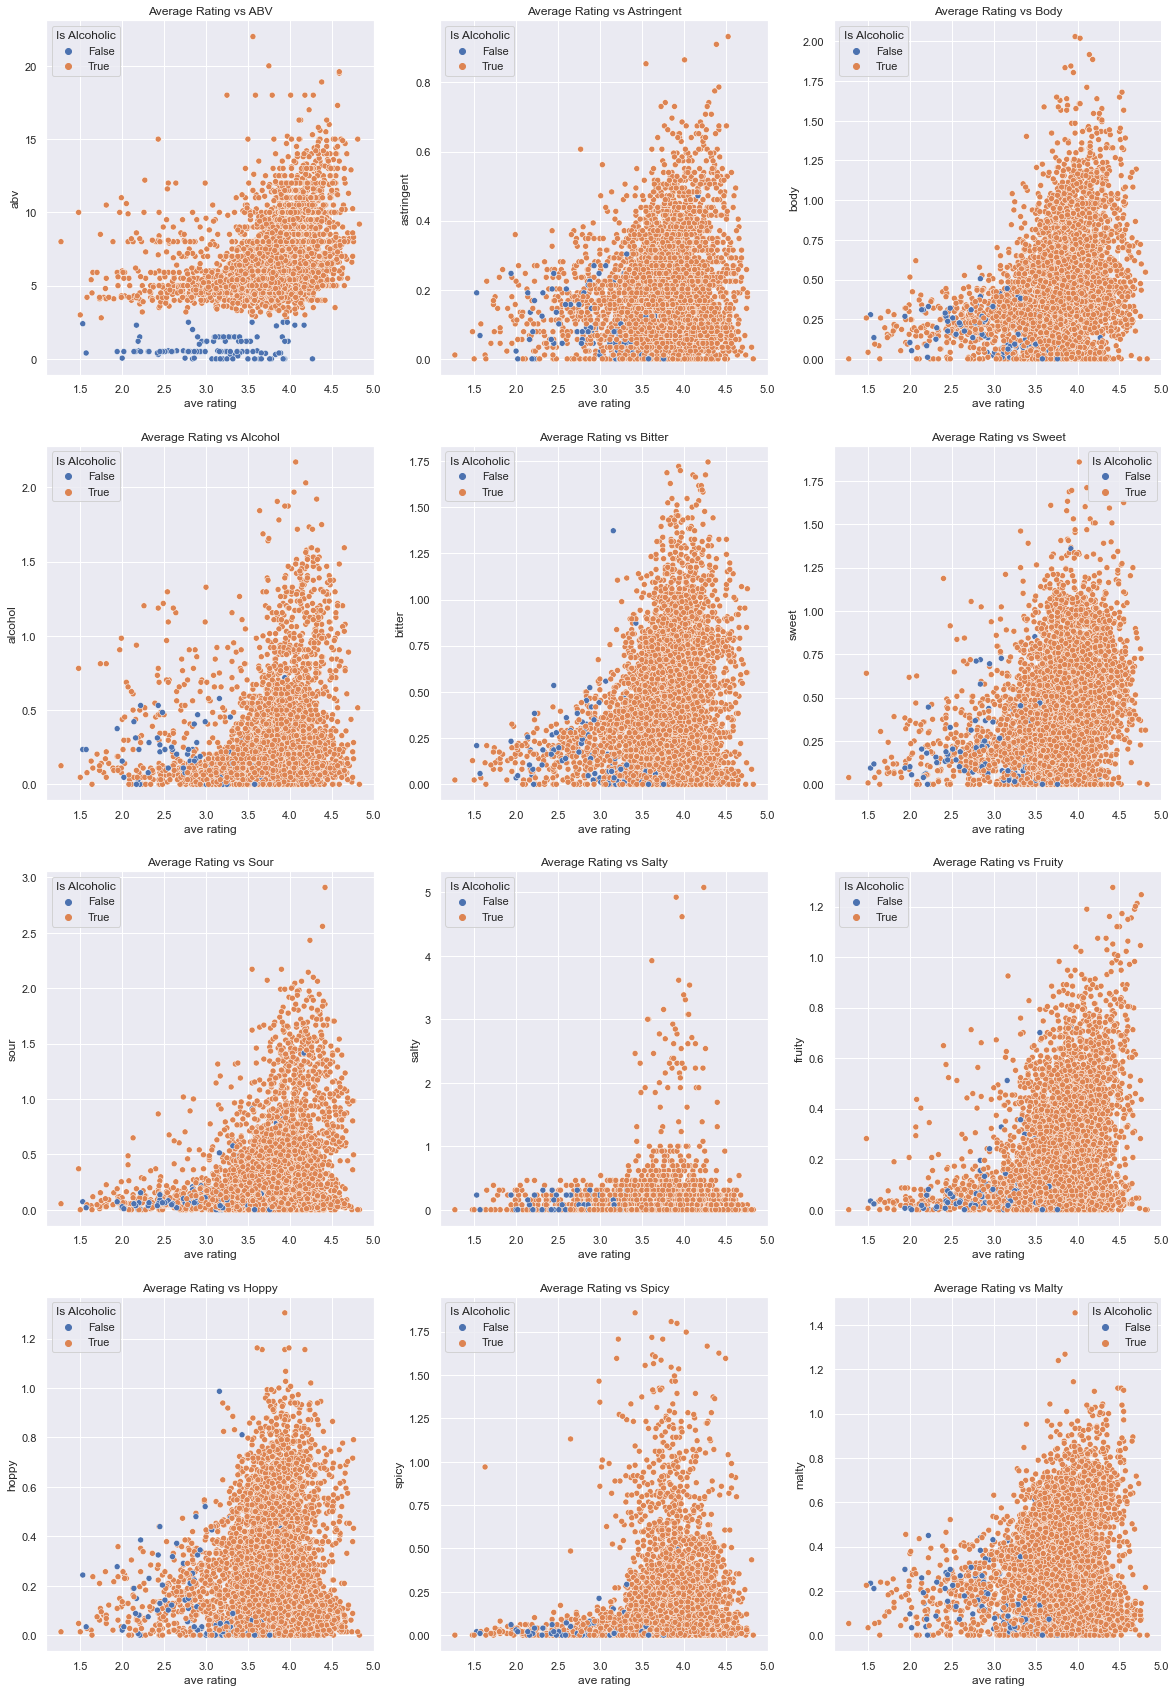

In [159]:
# Distributions
fig, axes = plt.subplots(nrows=4, ncols = 3, figsize = (20, 30))

plt.subplot(4, 3, 1)
sns.scatterplot(data = new_final, x = 'ave rating', y = 'abv', hue = 'Is Alcoholic').set(title='Average Rating vs ABV')

plt.subplot(4, 3, 2)
sns.scatterplot(data = new_final, x = 'ave rating', y = 'astringent', hue = 'Is Alcoholic').set(title='Average Rating vs Astringent')

plt.subplot(4, 3, 3)
sns.scatterplot(data = new_final, x = 'ave rating', y = 'body', hue = 'Is Alcoholic').set(title='Average Rating vs Body')

plt.subplot(4, 3, 4)
sns.scatterplot(data = new_final, x = 'ave rating', y = 'alcohol', hue = 'Is Alcoholic').set(title='Average Rating vs Alcohol')

plt.subplot(4, 3, 5)
sns.scatterplot(data = new_final, x = 'ave rating', y = 'bitter', hue = 'Is Alcoholic').set(title='Average Rating vs Bitter')

plt.subplot(4, 3, 6)
sns.scatterplot(data = new_final, x = 'ave rating', y = 'sweet', hue = 'Is Alcoholic').set(title='Average Rating vs Sweet')

plt.subplot(4, 3, 7)
sns.scatterplot(data = new_final, x = 'ave rating', y = 'sour', hue = 'Is Alcoholic').set(title='Average Rating vs Sour')

plt.subplot(4, 3, 8)
sns.scatterplot(data = new_final, x = 'ave rating', y = 'salty', hue = 'Is Alcoholic').set(title='Average Rating vs Salty')

plt.subplot(4, 3, 9)
sns.scatterplot(data = new_final, x = 'ave rating', y = 'fruity', hue = 'Is Alcoholic').set(title='Average Rating vs Fruity')

plt.subplot(4, 3, 10)
sns.scatterplot(data = new_final, x = 'ave rating', y = 'hoppy', hue = 'Is Alcoholic').set(title='Average Rating vs Hoppy')

plt.subplot(4, 3, 11)
sns.scatterplot(data = new_final, x = 'ave rating', y = 'spicy', hue = 'Is Alcoholic').set(title='Average Rating vs Spicy')

plt.subplot(4, 3, 12)
sns.scatterplot(data = new_final, x = 'ave rating', y = 'malty', hue = 'Is Alcoholic').set(title='Average Rating vs Malty')

In [160]:
#fig2 = sns.pairplot(data = new_final[['ave rating', 'fruity', 'hoppy', 'spicy', 'malty', 'Is Alcoholic']], hue = 'Is Alcoholic')
#fig2.fig.suptitle('Pairwise Relationships Between Average Rating, fruity, Hoppy, Spicy, Malty', y=1.05)
#fig3 = sns.pairplot(data = new_final[['ave rating', 'bitter', 'sweet', 'sour', 'salty', 'Is Alcoholic']], hue = 'Is Alcoholic')
#fig3.fig.suptitle('Pairwise Relationships Between Average Rating, Bitterness, Sweetness, Sourness, Saltiness', y=1.05)

Here we looked at the relationship between taste characteristics and Avg rating.  
For most of the characteristics, we observed: if average rating is low, then the given characteristic is likely to be low too. Conversely, the higher the rating gets, the higher the variability of the characteristic for the beer. For example: if the beer has a high rating, the beer can have a low, medium, or high sweetness score; but if the beer has a low rating, the beer is very much more likely to have a low sweetness score. 

# Models

In [ ]:
# renamed columns without spaces to be able to run models on the data

new_final = new_final.rename(columns = {'ave rating': 'avg_rating', 'Is Alcoholic': 'is_alcoholic'})
new_final.head()

,style,beer,key,abv,avg_rating,min ibu,max ibu,astringency,body,alcohol,...,sour,salty,fruits,hoppy,spices,malty,mouthfeel,taste,flavor_and_aroma,is_alcoholic
0,Altbier,ALTerior Motive,297.0,6.3,4.05,25.0,50.0,0.303371,0.628866,0.171875,...,0.414414,0.000000,0.229885,0.520270,0.141414,0.526316,0.396,0.482249,0.713018,True
1,Altbier,Ad Astra Ale,264.0,5.6,3.69,25.0,50.0,0.078652,0.309278,0.078125,...,0.117117,0.076923,0.074713,0.337838,0.060606,0.444976,0.168,0.295858,0.479290,True
2,Altbier,Alt-eration Ale,271.0,5.0,3.81,25.0,50.0,0.235955,0.443299,0.046875,...,0.063063,0.000000,0.057471,0.405405,0.090909,0.531100,0.268,0.340237,0.562130,True
3,Altbier,Altbier,262.0,4.7,4.00,25.0,50.0,0.382022,0.494845,0.140625,...,0.225225,0.076923,0.183908,0.459459,0.121212,0.578947,0.364,0.414201,0.689349,True
4,Altbier,Alternate Dimension,300.0,5.6,3.66,25.0,50.0,0.280899,0.515464,0.187500,...,0.180180,0.000000,0.120690,0.398649,0.262626,0.665072,0.348,0.452663,0.724852,True


In [ ]:
mod = smf.quantreg(('avg_rating ~  abv'), new_final)
res = mod.fit(q=0.90)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:             avg_rating   Pseudo R-squared:               0.1121
Model:                       QuantReg   Bandwidth:                     0.06521
Method:                 Least Squares   Sparsity:                        1.582
Date:                Mon, 05 Dec 2022   No. Observations:                 5348
Time:                        13:24:01   Df Residuals:                     5346
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7700      0.018    209.972      0.000       3.735       3.805
abv            0.0600      0.003     23.794      0.000       0.055       0.065


In [ ]:
mod = smf.quantreg(('avg_rating ~ astringent'), new_final)
res = mod.fit(q=0.90)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:             avg_rating   Pseudo R-squared:             0.006597
Model:                       QuantReg   Bandwidth:                     0.07745
Method:                 Least Squares   Sparsity:                        1.875
Date:                Mon, 05 Dec 2022   No. Observations:                 5348
Time:                        13:24:01   Df Residuals:                     5346
                                        Df Model:                            1
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.1814      0.014    290.118      0.000       4.153       4.210
astringency     0.2543      0.068      3.739      0.000       0.121       0.388


In [ ]:
mod = smf.quantreg(('avg_rating ~  body'), new_final)
res = mod.fit(q=0.90)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:             avg_rating   Pseudo R-squared:              0.02394
Model:                       QuantReg   Bandwidth:                     0.07347
Method:                 Least Squares   Sparsity:                        1.839
Date:                Mon, 05 Dec 2022   No. Observations:                 5348
Time:                        13:24:02   Df Residuals:                     5346
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1148      0.014    303.979      0.000       4.088       4.141
body           0.2328      0.026      9.089      0.000       0.183       0.283


In [ ]:
mod = smf.quantreg(('avg_rating ~  bitter'), new_final)
res = mod.fit(q=0.90)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:             avg_rating   Pseudo R-squared:             0.003181
Model:                       QuantReg   Bandwidth:                     0.07642
Method:                 Least Squares   Sparsity:                        1.940
Date:                Mon, 05 Dec 2022   No. Observations:                 5348
Time:                        13:24:02   Df Residuals:                     5346
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1996      0.013    313.854      0.000       4.173       4.226
bitter         0.0815      0.027      3.008      0.003       0.028       0.135


In [ ]:
mod = smf.quantreg(('avg_rating ~  sweet'), new_final)
res = mod.fit(q=0.90)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:             avg_rating   Pseudo R-squared:              0.04172
Model:                       QuantReg   Bandwidth:                     0.07597
Method:                 Least Squares   Sparsity:                        1.699
Date:                Mon, 05 Dec 2022   No. Observations:                 5348
Time:                        13:24:03   Df Residuals:                     5346
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0748      0.012    340.073      0.000       4.051       4.098
sweet          0.3325      0.023     14.305      0.000       0.287       0.378


In [ ]:
mod = smf.quantreg(('avg_rating ~  sour'), new_final)
res = mod.fit(q=0.90)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:             avg_rating   Pseudo R-squared:              0.03522
Model:                       QuantReg   Bandwidth:                     0.07234
Method:                 Least Squares   Sparsity:                        1.742
Date:                Mon, 05 Dec 2022   No. Observations:                 5348
Time:                        13:24:04   Df Residuals:                     5346
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1390      0.009    443.561      0.000       4.121       4.157
sour           0.2297      0.019     12.011      0.000       0.192       0.267


In [ ]:
mod = smf.quantreg(('avg_rating ~ salty'), new_final)
res = mod.fit(q=0.90)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:             avg_rating   Pseudo R-squared:            0.0006943
Model:                       QuantReg   Bandwidth:                     0.07755
Method:                 Least Squares   Sparsity:                        1.928
Date:                Mon, 05 Dec 2022   No. Observations:                 5348
Time:                        13:24:05   Df Residuals:                     5346
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2367      0.009    498.394      0.000       4.220       4.253
salty         -0.0433      0.031     -1.403      0.161      -0.104       0.017


In [ ]:
mod = smf.quantreg(('avg_rating ~ fruity'), new_final)
res = mod.fit(q=0.90)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:             avg_rating   Pseudo R-squared:              0.06716
Model:                       QuantReg   Bandwidth:                     0.07168
Method:                 Least Squares   Sparsity:                        1.753
Date:                Mon, 05 Dec 2022   No. Observations:                 5348
Time:                        13:24:05   Df Residuals:                     5346
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0960      0.011    361.929      0.000       4.074       4.118
fruits         0.4884      0.038     12.796      0.000       0.414       0.563


In [ ]:
mod = smf.quantreg(('avg_rating ~  hoppy'), new_final)
res = mod.fit(q=0.90)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:             avg_rating   Pseudo R-squared:             0.002401
Model:                       QuantReg   Bandwidth:                     0.07755
Method:                 Least Squares   Sparsity:                        1.982
Date:                Mon, 05 Dec 2022   No. Observations:                 5348
Time:                        13:24:05   Df Residuals:                     5346
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2639      0.014    306.169      0.000       4.237       4.291
hoppy         -0.1153      0.044     -2.646      0.008      -0.201      -0.030


In [ ]:
mod = smf.quantreg(('avg_rating ~ spicy'), new_final)
res = mod.fit(q=0.90)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:             avg_rating   Pseudo R-squared:             0.002986
Model:                       QuantReg   Bandwidth:                     0.07699
Method:                 Least Squares   Sparsity:                        1.867
Date:                Mon, 05 Dec 2022   No. Observations:                 5348
Time:                        13:24:06   Df Residuals:                     5346
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2100      0.009    461.694      0.000       4.192       4.228
spices         0.1100      0.028      3.935      0.000       0.055       0.165


In [ ]:
mod = smf.quantreg(('avg_rating ~ malty'), new_final)
res = mod.fit(q=0.90)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:             avg_rating   Pseudo R-squared:            0.0009600
Model:                       QuantReg   Bandwidth:                     0.07686
Method:                 Least Squares   Sparsity:                        1.911
Date:                Mon, 05 Dec 2022   No. Observations:                 5348
Time:                        13:24:06   Df Residuals:                     5346
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2079      0.017    248.036      0.000       4.175       4.241
malty          0.0716      0.046      1.553      0.120      -0.019       0.162


In [ ]:
mod = smf.quantreg(('avg_rating ~ style'), new_final)
res = mod.fit(q=0.90)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:             avg_rating   Pseudo R-squared:               0.1766
Model:                       QuantReg   Bandwidth:                     0.06963
Method:                 Least Squares   Sparsity:                        1.369
Date:                Mon, 05 Dec 2022   No. Observations:                 5348
Time:                        13:24:08   Df Residuals:                     5304
                                        Df Model:                           43
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    4.0500      0.058     69.723      0.000       3.936       4.164
style[T.Barleywine ]                         0.3400      0.071      4.779      0.000       0.201       0.479
style[T.Bit

In [ ]:
mod = smf.quantreg(('avg_rating ~  astringency*abv + body*abv + bitter*abv + sweet*abv + sour*abv + salty*abv + fruity*abv + hoppy*abv + spicy*abv + malty*abv + is_alcoholic*abv'), new_final)
res = mod.fit(q=0.90)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:             avg_rating   Pseudo R-squared:               0.2429
Model:                       QuantReg   Bandwidth:                     0.06050
Method:                 Least Squares   Sparsity:                        1.260
Date:                Mon, 05 Dec 2022   No. Observations:                 5348
Time:                        13:24:12   Df Residuals:                     5324
                                        Df Model:                           23
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.7964      0.069     55.029      0.000       3.661       3.932
is_alcoholic[T.True]        -0.1240      0.069     -1.791      0.073      -0.260       0.012
astringency                 -0.0463      0.203     -0.228      0.820      -

c:\Users\nmoli\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


# Ethics & Privacy

Our potential dataset (Untappd and BeerAdvocates) does not include any personal identifiable information. If we collect more data with personally identifiable information, we will disregard the sensitive information, such as a person’s name, in our report. It does contain anonymous comments about the beer. Since these comments are anonymous, their privacy is protected. 

Both of the companies the data is coming from are not affiliated with any beer companies, so we don’t have any evidence of them being biased.

We will make inferences from the results obtained from the experiment and not based on our hypothesis.

Beer is an alcoholic beverage. So, to purchase it, individuals are verified to ensure they are of age. Our dataset gathers information from individuals that are legally allowed to purchase beer. 

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*